In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
!pip install -q lightning

In [3]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from lightning import seed_everything
from torch.optim import lr_scheduler
from sklearn.manifold import TSNE
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from torch.optim import Adam
import seaborn as sns
import lightning as L
import torch

seed_everything(42)
plt.style.use('ggplot')

INFO: Seed set to 42


# Loading data

In [4]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [5]:
train.shape, test.shape

((42000, 785), (28000, 784))

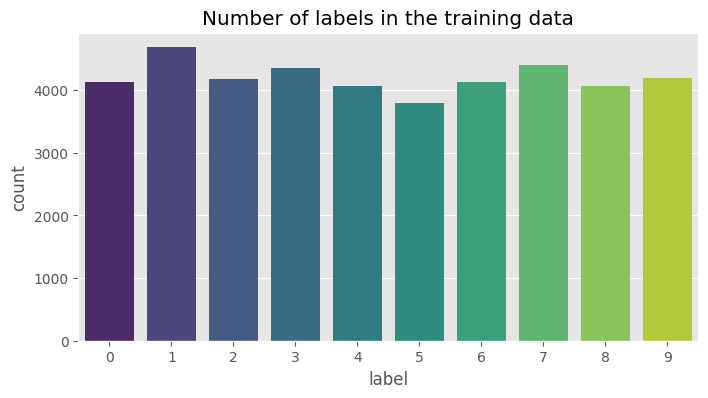

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(x="label", data=train, palette="viridis")
plt.title('Number of labels in the training data')
plt.show()

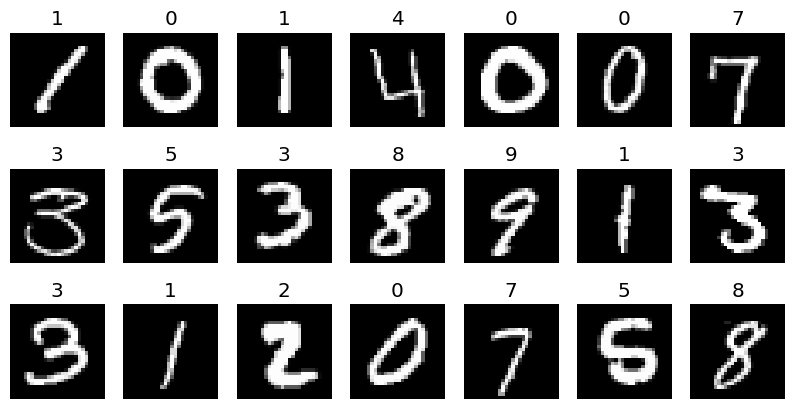

In [7]:
fig, ax = plt.subplots(3, 7, figsize=(10, 5))
for i in range(21):
    plt.subplot(3, 7, i+1)
    img = train.iloc[i, 1:].values
    img = img.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.title(train.iloc[i, 0])
    plt.axis('off')
plt.show()

# Visualizing with t-SNE

In [8]:
X = train.drop('label', axis=1)
y = train['label']

tsne = TSNE(
    random_state=42,
    n_components=2,
    verbose=0,
    perplexity=40,
    n_iter=300
).fit_transform(X)

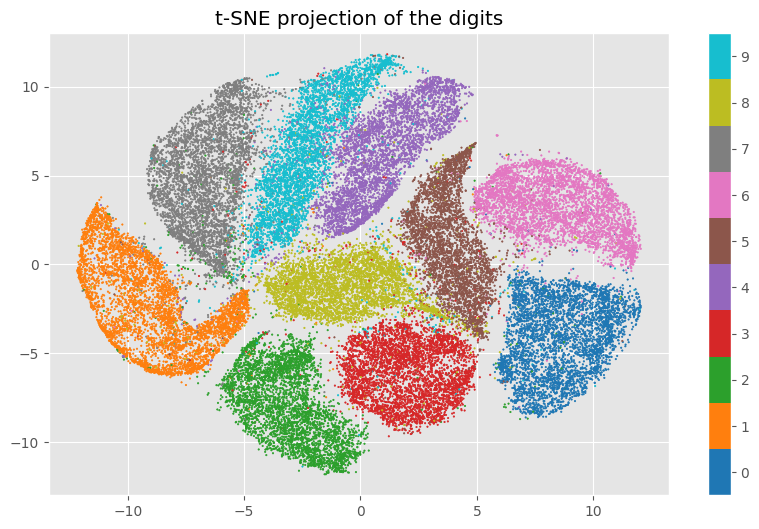

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=1, c=y, cmap='tab10')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('t-SNE projection of the digits')
plt.show()

# Creating datamodule for training

In [10]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_val: pd.DataFrame,
        y_val: pd.Series,
        batch_size: int
    ):
        super().__init__()
        self.X_train = torch.tensor(X_train.values, dtype=torch.float32)
        self.y_train = torch.tensor(y_train.values, dtype=torch.long)
        self.X_val = torch.tensor(X_val.values, dtype=torch.float32)
        self.y_val = torch.tensor(y_val.values, dtype=torch.long)
        self.batch_size = batch_size

    def train_dataloader(self) -> DataLoader:
        dataset = TensorDataset(self.X_train, self.y_train)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self) -> DataLoader:
        dataset = TensorDataset(self.X_val, self.y_val)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((37800, 784), (4200, 784), (37800,), (4200,))

# Defining CNN model

In [12]:
class CNN(L.LightningModule):
    def __init__(self, input_dim: int, output_dim: int, learning_rate: float):
        super().__init__()
        self.learning_rate = learning_rate
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(
            32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64*7*7, 128)
        self.fc2 = torch.nn.Linear(128, output_dim)
        self.relu = torch.nn.ReLU()
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.loss = torch.nn.CrossEntropyLoss()

        self.train_accuracy = Accuracy(
            task='MULTICLASS', num_classes=output_dim)
        self.validation_accuracy = Accuracy(
            task='MULTICLASS', num_classes=output_dim)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(-1, 64*7*7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        logs = {
            "loss": loss,
            'train_loss': loss,
            'train_accuracy': self.train_accuracy(y_hat, y)
        }

        self.log_dict(
            logs,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        logs = {
            'val_loss': loss,
            'val_accuracy': self.validation_accuracy(y_hat, y)
        }

        self.log_dict(
            logs,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=False
        )

    def configure_optimizers(self):
        optimizer =  Adam(self.parameters(), lr=self.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=False, mode='max')
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_accuracy'
            }
        }

# Training

In [13]:
BATCH_SIZE = 64
LEARNING_RATE = 0.0003
MAX_EPOCHS = 100

In [14]:
data_module = DataModule(X_train, y_train, X_val, y_val, BATCH_SIZE)
model = CNN(X_train.shape[1], 10, LEARNING_RATE)

In [15]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, mode="max", verbose=False, check_on_train_epoch_end=True)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[lr_monitor, early_stopping]
)

trainer.fit(model, data_module)
trainer.validate(model, data_module)
trainer.save_checkpoint("model.ckpt")

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-02 16:07:44.809077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 16:07:44.809279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 16:07:44.982618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: 
  | Name                | Type               | Params
-----------------------------------------------------------
0 | conv1               | Conv2d             | 320   
1 | conv2          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Inferencing

In [16]:
model = CNN.load_from_checkpoint("model.ckpt", input_dim=X_train.shape[1], output_dim=10, learning_rate=LEARNING_RATE)
model.eval()

X_test = torch.tensor(test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

predictions = []
for batch in test_loader:
    x = batch[0]
    y_hat = model(x)
    predictions.extend(torch.argmax(y_hat, dim=1).tolist())
    
submission = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)